In [1]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import os, sys
exec(open("init_notebook.py").read())
from DataTools import DataTools
from Extractor import Extractor
from DataCleaner import DataCleaner
from RepoTools import RepoTools

current working dir/Volumes/Zarif/myStuff/research/repoPaper/src


In [2]:
%load_ext autoreload
%autoreload 2

### Load all the necessary datasets 

In [172]:
# mainDataSet
mainDatasetPath = os.path.join(os.curdir, "../data/mainData.csv")
companyDf = pd.read_csv(mainDatasetPath)

# companyToRepos
companyToRepos = Extractor.getConfig()

# DataByCIDAndYear
dataByCidYear = DataTools.loadCSVFromOutput('finalStuff/DataByCIDAndYearV3')

# matched_papers
matchedPapersInfo = DataTools.loadCSVFromOutput('finalStuff/matched_papersV3')
matchedPapersInfo.repo_link = matchedPapersInfo.repo_link.str.lower()

# pwc
pwc = pd.read_csv(os.path.join(os.pardir, 'data/papersWithCode.csv'))
pwc['repo_url'] = pwc['repo_url'].str.lower()

# pwc paper without links 
pwcPapers = pd.read_csv(os.path.join(os.pardir, 'data/pwcAll.csv'))

# Paper Titles Matched By PWC and companyDf
paperTitles = [title.lower() for title in companyDf['Title']]
matchedPapersInPWC = pwc[pwc['paper_title'].str.lower().isin(paperTitles)]

# getting all the matches having company usernames
usernames = []
for _ in companyToRepos:
    a = ['/' + username.lower() + '/' for username in _['repos']]
    usernames.extend(a)
    
matchedHavingUsername = matchedPapersInPWC[matchedPapersInPWC.repo_url.str.contains('|'.join(usernames))]

# all the matches not having company usernames
matchedNotHavingUsername = matchedPapersInPWC[~matchedPapersInPWC.isin(matchedHavingUsername)].dropna()

# companyPWC
companyPWC = pwc[pwc.repo_url.str.contains('|'.join(usernames))]

# matched papers in pwc having company usernames and mentioning paper in the github
matchedHavingUsernameAndGithubMention = matchedHavingUsername[matchedHavingUsername.mentioned_in_github==True]

In [190]:
len(matchedPapersInfo)

1594

In [187]:
def getPath(filename):
    return os.path.join(os.curdir, '../figs/' + filename)

### Pi Chart For Number of Company with N users

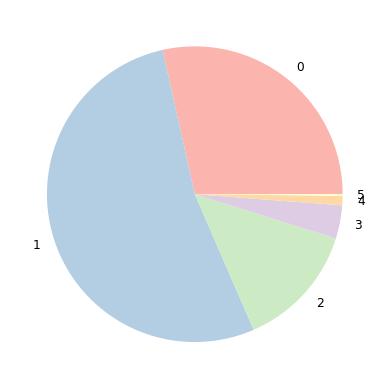

In [183]:
nUsers = []
for _ in companyToRepos:
    nUsers.append(len(_['repos']))
    
nUsersTonCompanies = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}
for nUser in nUsers:
    nUsersTonCompanies[nUser] += 1
  
labels = ['0', '1', '2', '3', '4', '5']
data = nUsersTonCompanies.values()
palette_color = sns.color_palette('Pastel1')
plt.pie(data, labels=labels, colors=palette_color)
# plt.show()
sns.set_context('paper')
plt.savefig(getPath('pichart.png'), dpi=300, bbox_inches='tight', transparent=True)

###  finding the top users in company papers having ***matching*** paper mentioned in github

In [193]:
repo_urls = list(matchedHavingUsername[matchedHavingUsername.mentioned_in_github == True].repo_url)
import re
link_pattern = r'https://github.com/([\w\-]*)/[\w\-]*'

usernames = [re.findall(link_pattern, repo_url)[0] for repo_url in repo_urls if len(re.findall(link_pattern, repo_url)) > 0]
from collections import Counter
usernames_count = Counter(usernames)
usernames_count.most_common()[:10]

[('facebookresearch', 287),
 ('microsoft', 223),
 ('tensorflow', 148),
 ('google-research', 108),
 ('ibm', 81),
 ('google', 76),
 ('nvlabs', 44),
 ('amazon-research', 37),
 ('deepmind', 35),
 ('google-research-datasets', 34)]

###  finding the top users in company papers having ***matching*** paper not mentioned in github

In [194]:
repo_urls = list(matchedHavingUsername[matchedHavingUsername.mentioned_in_github == False].repo_url)
import re
link_pattern = r'https://github.com/([\w\-]*)/[\w\-]*'

usernames = [re.findall(link_pattern, repo_url)[0] for repo_url in repo_urls if len(re.findall(link_pattern, repo_url)) > 0]
from collections import Counter
usernames_count = Counter(usernames)
usernames_count.most_common()[:10]

[('google-research', 167),
 ('microsoft', 110),
 ('tensorflow', 76),
 ('deepmind', 58),
 ('facebookresearch', 48),
 ('ibm', 47),
 ('alibaba', 33),
 ('google', 29),
 ('huawei-noah', 23),
 ('nvlabs', 12)]

###  finding the top users in our finding

In [195]:
repo_urls = list(matchedPapersInfo.repo_link)
import re
link_pattern = r'https://github.com/([\w\-]*)/[\w\-]*'

usernames = [re.findall(link_pattern, repo_url)[0] for repo_url in repo_urls if len(re.findall(link_pattern, repo_url)) > 0]
from collections import Counter
usernames_count = Counter(usernames)
usernames_count.most_common()[:10]

[('microsoft', 275),
 ('facebookresearch', 197),
 ('ibm', 125),
 ('google-research', 104),
 ('google', 79),
 ('google-research-datasets', 50),
 ('deepmind', 49),
 ('nvlabs', 45),
 ('pfnet-research', 24),
 ('tencent', 20)]

### finding missed by us papers (Facebook)

In [201]:
papersByFacebookPWC = matchedPapersInPWC[(matchedPapersInPWC.repo_url.str.contains('facebookresearch')) & (matchedPapersInPWC.mentioned_in_github==True)]
papersByFacebookUs = matchedPapersInfo[matchedPapersInfo.repo_link.str.contains('facebookresearch')]
notIncludedPapers = []
big = list(papersByFacebookPWC.paper_title.str.lower())
smol = list(papersByFacebookUs.Title.str.lower())
for paper in big:
    if paper not in smol:
        notIncludedPapers.append(paper)
        
missedByUs = papersByFacebookPWC[papersByFacebookPWC.paper_title.str.lower().isin(notIncludedPapers)]
missedByUs.iloc[0:5]

,paper_url,paper_title,paper_arxiv_id,paper_url_abs,paper_url_pdf,repo_url,is_official,mentioned_in_paper,mentioned_in_github,framework
513,https://paperswithcode.com/paper/continuous-co...,Continuous control with deep reinforcement lea...,1509.02971,https://arxiv.org/abs/1509.02971v6,https://arxiv.org/pdf/1509.02971v6.pdf,https://github.com/facebookresearch/horizon,False,False,True,pytorch
676,https://paperswithcode.com/paper/a-distributio...,A Distributional Perspective on Reinforcement ...,1707.06887,http://arxiv.org/abs/1707.06887v1,http://arxiv.org/pdf/1707.06887v1.pdf,https://github.com/facebookresearch/horizon,False,False,True,pytorch
4375,https://paperswithcode.com/paper/doubly-robust...,Doubly Robust Off-policy Value Evaluation for ...,1511.03722,http://arxiv.org/abs/1511.03722v3,http://arxiv.org/pdf/1511.03722v3.pdf,https://github.com/facebookresearch/horizon,False,False,True,pytorch
4376,https://paperswithcode.com/paper/optimal-and-a...,Optimal and Adaptive Off-policy Evaluation in ...,1612.01205,http://arxiv.org/abs/1612.01205v2,http://arxiv.org/pdf/1612.01205v2.pdf,https://github.com/facebookresearch/horizon,False,False,True,pytorch
4381,https://paperswithcode.com/paper/multi-armed-b...,Multi-Armed Bandits in Metric Spaces,0809.4882,https://arxiv.org/abs/0809.4882v1,https://arxiv.org/pdf/0809.4882v1.pdf,https://github.com/facebookresearch/horizon,False,False,True,pytorch


106

###  finding the top users in non company papers having ***matching*** paper 

In [180]:
repo_urls = list(matchedNotHavingUsername[matchedNotHavingUsername.mentioned_in_github == True].repo_url)
import re
link_pattern = r'https://github.com/([\w\-]*)/[\w\-]*'

usernames = [re.findall(link_pattern, repo_url)[0] for repo_url in repo_urls if len(re.findall(link_pattern, repo_url)) > 0]
from collections import Counter
usernames_count = Counter(usernames)
usernames_count.most_common()

[('rwightman', 41),
 ('osmr', 41),
 ('sakib1263', 39),
 ('lucidrains', 37),
 ('paddlepaddle', 30),
 ('huggingface', 27),
 ('mind23-2', 27),
 ('jiajunhua', 26),
 ('marload', 26),
 ('shenweichen', 26),
 ('2023-mindspore-1', 25),
 ('thunlp', 25),
 ('qilei123', 25),
 ('rickyhong', 23),
 ('clovaai', 22),
 ('stick-to', 21),
 ('sayakpaul', 21),
 ('swz30', 20),
 ('eriklindernoren', 20),
 ('yangyucheng000', 19),
 ('d-x-y', 18),
 ('researchmm', 17),
 ('deeplearning-wisc', 17),
 ('open-mmlab', 17),
 ('ruotianluo', 17),
 ('benedekrozemberczki', 16),
 ('sooftware', 16),
 ('huanzhang12', 16),
 ('xue-pai', 15),
 ('qengineering', 15),
 ('tensorpack', 15),
 ('hrnet', 14),
 ('cambridge-mlg', 13),
 ('kingcong', 13),
 ('taki0112', 13),
 ('vita-group', 13),
 ('lornatang', 13),
 ('titu1994', 12),
 ('rishikksh20', 12),
 ('hkust-knowcomp', 12),
 ('woctezuma', 12),
 ('brain-research', 12),
 ('tencentyouturesearch', 12),
 ('deci-ai', 12),
 ('chainer', 11),
 ('hilab-git', 11),
 ('zjzstu', 11),
 ('junnyu', 11),
 